# Using a predefined random seed and saving the outputs at each step. This is for reproducibility. Simulation without noise

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import dataclasses as dt

In [3]:
import os
import shutil
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline28IDB.optimization.common as opt_common
import aps.ai.autoalignment.beamline28IDB.optimization.configs as configs
import aps.ai.autoalignment.beamline28IDB.optimization.movers as movers
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
#from aps.ai.autoalignment.beamline28IDB.facade.focusing_optics_factory import (
#    ExecutionMode,
#    focusing_optics_factory_method,
#)

from aps.ai.autoalignment.beamline28IDB.facade.focusing_optics_factory import (
    ExecutionMode,
    focusing_optics_factory_method,
)
from aps.ai.autoalignment.beamline28IDB.optimization.optuna_botorch import OptunaOptimizer
from aps.ai.autoalignment.beamline28IDB.simulation.facade.focusing_optics_interface import (
    Layout,
    get_default_input_features,
)
from aps.ai.autoalignment.common.simulation.facade.parameters import Implementors
from aps.ai.autoalignment.common.util import clean_up
from aps.ai.autoalignment.common.util.common import AspectRatio, ColorMap, PlotMode
from aps.ai.autoalignment.common.util.shadow.common import (
    EmptyBeamException,
    HybridFailureException,
    PreProcessorFiles,
    load_shadow_beam,
)
from aps.ai.autoalignment.common.util.wrappers import load_beam

import aps.ai.autoalignment.beamline28IDB.optimization.analysis_utils as analysis
import aps.ai.autoalignment.beamline28IDB.optimization.analysis_plot_utils as apu
from datetime import datetime
import joblib
import matplotlib as mpl
import cmasher as cm
import colorcet as cc

from epics import ca
ca.finalize_libca()

%matplotlib inline

28-ID - VKB Pitch Motor Resolution: 2e-05 deg


**** The executable "caRepeater" couldn't be located
**** because of errno = "No such file or directory".
**** You may need to modify your PATH environment variable.
**** Unable to start "CA Repeater" process.


In [4]:
mpl.rcParams.update({'font.size': 16, 'text.usetex':True})

In [5]:
DEFAULT_RANDOM_SEED = 10

In [6]:
class OptimizationParameters:
    def __init__(self):
        self.move_motors_ranges = configs.DEFAULT_MOVEMENT_RANGES

        self.params = {
            "sum_intensity_soft_constraint": 1e3,
            "sum_intensity_hard_constraint": 1e3,
            #            "centroid_sigma_loss_threshold_dependency": CentroidSigmaLossThresholdDependency.FULLY_DYNAMIC,
            #            "centroid_sigma_loss_hard_thresholds": [0.01, 0.03],
            "loss_parameters": ["fwhm", "peak_distance", "negative_log_peak_intensity"],
            "multi_objective_optimization": True,
            "n_pitch_trans_motor_trials": 50,
            "n_all_motor_trials": 100,
            "moo_thresholds": {"fwhm":0.02}
        }

In [7]:
def setup_work_dir():
    root_dir = Path(aps.__path__[0]).parents[0]
    work_dir = root_dir / "work_directory/28-ID"
    os.chdir(work_dir)

In [8]:
def print_beam_attributes(loss_parameters, hist, dw, title):
    loss_dw_functions = {
        "peak_distance": opt_common._get_peak_distance_from_dw,
        "centroid": opt_common._get_centroid_distance_from_dw,
        "sigma": opt_common._get_sigma_from_dw,
        "fwhm": opt_common._get_fwhm_from_dw,
        "negative_log_peak_intensity": lambda d: -np.log(opt_common._get_peak_intensity_from_dw(d))
    }
    loss_hist_functions = {
        "log_weighted_sum_intensity": lambda hist: np.log(opt_common._get_weighted_sum_intensity_from_hist(hist, 2))
    }

    attribs = {}
    for ltype in loss_parameters:
        if ltype in loss_dw_functions:
            loss = loss_dw_functions[ltype](dw)
        if ltype in loss_hist_functions:
            loss = loss_hist_functions[ltype](hist)
        attribs[ltype] = loss
        print(f"{title} system {ltype}: {loss:4.3e}")
    return attribs

In experiments, the perturbed max is about 400 times higher than the noise level. This seems to hold in sim with noise level 0.5

In [9]:
2560 * 0.65 * 1e-3

1.6640000000000001

In [10]:
detector_x = 2160 * 0.65 * 1e-3
detector_y = 2560 * 0.65 * 1e-3
cp = opt_common.CalculationParameters(
    xrange= [-detector_x / 2, detector_x / 2],
    yrange = [-detector_y / 2, detector_y / 2],
    nbins_h = 1024,
    nbins_v = 1024,
    use_denoised = False,
    random_seed = DEFAULT_RANDOM_SEED,
    add_noise = False,
    calculate_over_noise= False,
    implementor=Implementors.SHADOW,
    percentage_fluctuation=50,
    noise=0.5,
    save_images=True,
    every_n_images=1
   )

xrange_plot = [-0.3, 0.3]
yrange_plot = [-0.3, 0.3]

ppm = opt_common.PlotParameters(xrange=xrange_plot, yrange=yrange_plot, nbins_h = cp.nbins_h // 2, nbins_v = cp.nbins_v // 2)


In [11]:
cur_dir = Path.cwd().resolve()
save_dir = cur_dir / 'nf_fwhm_pl_pi'
save_dir.mkdir(exist_ok=True)

In [12]:
setup_work_dir()
clean_up()

print(cp)

CalculationParameters(execution_mode=0, implementor=0, xrange=[-0.7020000000000001, 0.7020000000000001], yrange=[-0.8320000000000001, 0.8320000000000001], nbins_h=1024, nbins_v=1024, do_gaussian_fit=False, use_denoised=False, from_raw_image=True, random_seed=10, add_noise=False, noise=0.5, percentage_fluctuation=50, calculate_over_noise=False, noise_threshold=1.5, reference_h=0.0, reference_v=0.0, save_images=True, every_n_images=1, rng=Generator(PCG64) at 0x7FEAB1A5D820)


In [13]:
ppm

PlotParameters(implementor=0, title='X,Z', xrange=[-0.3, 0.3], yrange=[-0.3, 0.3], nbins_h=512, nbins_v=512, plot_mode=0, aspect_ratio=0, color_map=<matplotlib.colors.ListedColormap object at 0x7fea901f6df0>)

In [14]:
opt_params = OptimizationParameters()

print("Motors and movement ranges")
print(opt_params.move_motors_ranges)

print("Optimization parameters")
print(opt_params.params)

Motors and movement ranges
{'hb_1': [-25, 25], 'hb_2': [-25, 25], 'hb_pitch': [-0.002, 0.002], 'hb_trans': [-0.03, 0.03], 'vb_bender': [-20.0, 20.0], 'vb_pitch': [-0.002, 0.002], 'vb_trans': [-0.03, 0.03]}
Optimization parameters
{'sum_intensity_soft_constraint': 1000.0, 'sum_intensity_hard_constraint': 1000.0, 'loss_parameters': ['fwhm', 'peak_distance', 'negative_log_peak_intensity'], 'multi_objective_optimization': True, 'n_pitch_trans_motor_trials': 50, 'n_all_motor_trials': 100, 'moo_thresholds': {'fwhm': 0.02}}


In [15]:
input_beam_path = "primary_optics_system_beam.dat"

clean_up()

# Initializing the focused beam from simulation
input_features = get_default_input_features(layout=Layout.AUTO_FOCUSING)
input_beam = load_shadow_beam(input_beam_path)
focusing_system = focusing_optics_factory_method(
    execution_mode=ExecutionMode.SIMULATION,
    implementor=Implementors.SHADOW,
    bender=True,
)

focusing_system.initialize(
    input_photon_beam=input_beam,
    rewrite_preprocessor_files=PreProcessorFiles.NO,
    layout=Layout.AUTO_FOCUSING,
    input_features=input_features,
)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


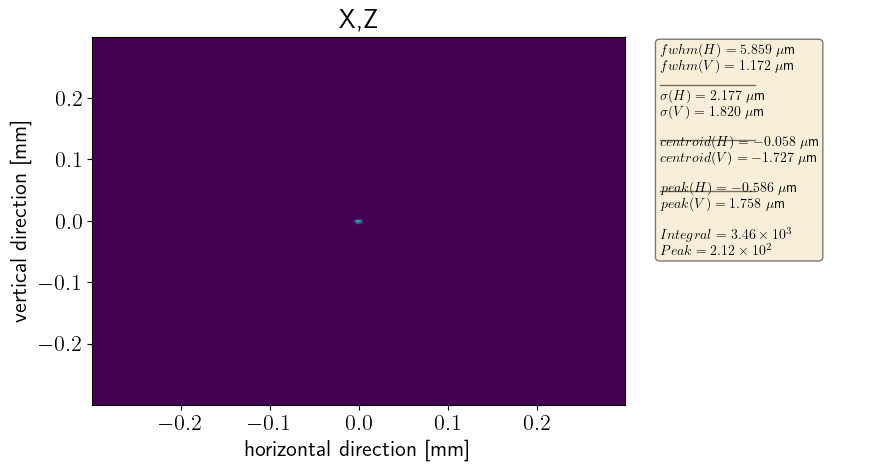

In [16]:
beam, hist, dw = opt_common.get_beam_hist_dw(cp=cp,focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(photon_beam=beam, ppm=ppm)

In [ ]:
focused_beam = {'dw': dw, 'hist': hist}
joblib.dump(focused_beam, f'{save_dir}/focused_beam.joblib', compress=5)

In [ ]:
!pwd

In [ ]:
m2 = apu.CMAP

In [ ]:
m2

In [ ]:
maxcount = hist.data_2D.max()

In [ ]:
maxcount

In [ ]:
attribs_focus = print_beam_attributes(opt_params.params['loss_parameters'], hist, dw, "Focused beam")

In [17]:
mots = list(opt_params.move_motors_ranges.keys())
initial_absolute_positions = {k: movers.get_absolute_positions(focusing_system, k)[0] for k in mots}
print("Focused absolute position are", initial_absolute_positions)



Focused absolute position are {'hb_1': -168.0, 'hb_2': -161.0, 'hb_pitch': 0.17188733853924987, 'hb_trans': 0.0, 'vb_bender': 419.0, 'vb_pitch': 0.17188733853924987, 'vb_trans': 0.0}


In [18]:
opt_params.move_motors_ranges #= {k: np.array(v) / 2 for k,v in opt_params.move_motors_ranges.items()}

{'hb_1': [-25, 25],
 'hb_2': [-25, 25],
 'hb_pitch': [-0.002, 0.002],
 'hb_trans': [-0.03, 0.03],
 'vb_bender': [-20.0, 20.0],
 'vb_pitch': [-0.002, 0.002],
 'vb_trans': [-0.03, 0.03]}

In [19]:
# Adding random perturbation to the motor values
initial_movement, focusing_system, (beam_init, hist_init, dw_init) = opt_common.get_random_init(
    focusing_system=focusing_system,
    motor_types_and_ranges=opt_params.move_motors_ranges,
    intensity_sum_threshold=opt_params.params["sum_intensity_hard_constraint"],
    cp=cp,
    
)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
Random initialization is (ABSOLUTE) ['hb_1', 'hb_2', 'hb_pitch', 'hb_trans', 'vb_bender', 'vb_pitch', 'vb_trans'] [-145.2, -175.6, 0.17058733853924987, -0.042, 419.5, 0.17042733853924988, 0.0113]
Random initialization is (RELATIVE) ['hb_1', 'hb_2', 'hb_pitch', 'hb_trans', 'vb_bender', 'vb_pitch', 'vb_trans'] [22.800085481448768, -14.615909496042656, 0.001313779541098123, -0.021043072615078783, 0.5121846574625941, -0.0014563215839179734, 0.011342188786867866]


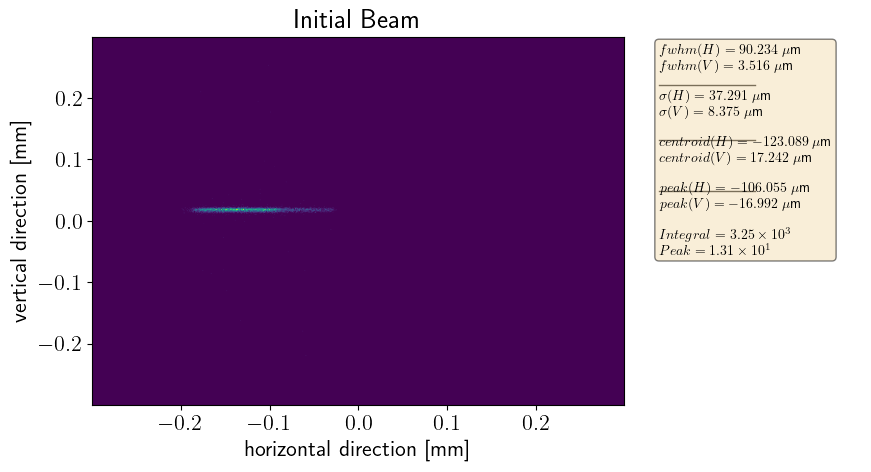

Perturbed beam system fwhm: 8.918e-02
Perturbed beam system peak_distance: 1.388e-01
Perturbed beam system negative_log_peak_intensity: -3.044e+00


In [20]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(
    photon_beam=beam_pert, ppm=ppm,
    title="Initial Beam",
)
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

In [21]:
{k: movers.get_absolute_positions(focusing_system, k)[0] for k in mots}

{'hb_1': -145.2,
 'hb_2': -175.6,
 'hb_pitch': 0.17058733853924987,
 'hb_trans': -0.042,
 'vb_bender': 419.5,
 'vb_pitch': 0.17042733853924988,
 'vb_trans': 0.0113}

In [ ]:
hist_pert.data_2D.max()

In [ ]:
dwd = dw_pert._DictionaryWrapper__dictionary
plt.figure(figsize=[7,7], constrained_layout=True)
plt.pcolormesh(hist_pert.hh, hist_pert.vv, hist_pert.data_2D.T, cmap=m2)#, norm=mpl.colors.LogNorm(1, 4e2))
plt.xlim(-0.05,0.05)
plt.ylim(-0.05,0.05)
plt.axhline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.axvline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.xlabel('Horizontal (mm)')
plt.ylabel('Vertical (mm)')
plt.title("Initial structure")
plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

ax = plt.gca()
ax.set_aspect('equal')

text = (f"{'fwhm(H)':<6} = {dwd['h_fwhm']: 4.3f} mm\n"
             f"{'fwhm(V)':<9} = {dwd['v_fwhm']: 4.3f} mm\n"
             f"{'peak(H)':<9} = {dwd['h_peak']: 4.3f} mm\n"
             f"{'peak(V)':<9} = {dwd['v_peak']: 4.3f} mm\n"
             f"{'peak int':<9} = {dwd['peak_intensity']: 3.2e} ph")
ax.text(0.055, 0.13, text, color='black', alpha=0.9, fontsize=14,
        bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7), transform=ax.transAxes)
plt.show()

In [ ]:
perturbed_positions = initial_movement + np.array(list(initial_absolute_positions.values()))

#### Calculating without removing noise

In [ ]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(
    photon_beam=beam_pert,
    title="Initial Beam",
    ppm=ppm
)

In [ ]:
hist_pert.data_2D.max()

In [ ]:
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

In [ ]:
opt_params = OptimizationParameters()

In [ ]:
import aps.ai.autoalignment.beamline28IDB.optimization.optuna_botorch as opter

In [ ]:
# Now the optimization
opt_trial = opter.OptunaOptimizer(calculation_parameters=cp,
    focusing_system=focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    dump_directory=save_dir
    )

In [ ]:
moo_thresholds = opt_params.params["moo_thresholds"]
for ltype in opt_params.params["loss_parameters"]:
    if ltype not in moo_thresholds:
        moo_thresholds[ltype] = opt_trial.get_beam_property_function_for_loss(ltype)()

In [ ]:
attribs_init

In [ ]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}#, "peak_distance": attribs_init["peak_distance"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds=moo_thresholds
)

In [ ]:
opt_trial.trials(100)#, trial_motor_types=['hb_pitch', 'hb_trans', 'vb_pitch', 'vb_trans'])

In [ ]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
#plt.scatter(*attribs_focus.values(), color='green')

In [ ]:
joblib.dump(opt_trial.study.trials, 
            save_dir /"trials.joblib", compress=4)

### This is the analysis part

In [ ]:
hist_dir = Path(save_dir)
hist_dir.exists()

In [ ]:
trials_file = save_dir / "trials.joblib"

In [ ]:
study = analysis.create_study_from_trials(trials_file, n_objectives=3)
n_steps = len(study.trials)

In [ ]:
hists = analysis.load_histograms_from_files(n_steps, hist_dir, extension='gz')

In [ ]:
nash_trial, nash_idx, n_doms = analysis.select_nash_equil_trial_from_pareto_front(study)

In [ ]:
best_hists = []
for t in study.best_trials:
    print("Trial number", t.number)
    print(f"Trial values: peak_distance {t.values[1]:4.3e} fwhm {t.values[0]:4.3e} int {t.values[2]:4.3e}")
    print("Trial dw:")
    
    dw = dict(t.user_attrs["dw"]._DictionaryWrapper__dictionary)
    print(dw)
    print("Actual fwhm", opt_common._get_fwhm_from_dw(t.user_attrs["dw"]))
    hist = hists[t.number]
    plt.figure(figsize=[7,7], constrained_layout=True)
    plt.pcolormesh(hist.hh, hist.vv, hist.data_2D.T, cmap=m2)#, norm=mpl.colors.LogNorm(1, 4e2))
    #plt.xlim(-0.04,0.04)
    #plt.ylim(-0.04,0.04)
    plt.axhline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
    plt.axvline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
    plt.xlabel('Horizontal (mm)')
    plt.ylabel('Vertical (mm)')
    plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

    ax = plt.gca()
    ax.set_aspect('equal')
    if t.number == nash_trial.number:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(4)
            ax.spines[axis].set_color('orange')

    plt.title(t.number)
    plt.show()

In [ ]:

tnum = nash_trial.number
dw = dict(**study.trials[tnum].user_attrs["dw"]._DictionaryWrapper__dictionary)
hist = hists[tnum]
plt.figure(figsize=[7,7], constrained_layout=True)
plt.pcolormesh(hist.hh, hist.vv, hist.data_2D.T, cmap=m2, norm=mpl.colors.LogNorm(0.3, 4e2))
plt.xlim(-0.25,0.25)
plt.ylim(-0.25,0.25)
plt.axhline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.axvline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.xlabel('Horizontal (mm)')
plt.ylabel('Vertical (mm)')
plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

ax = plt.gca()
ax.set_aspect('equal')

text = (f"{'fwhm(H)':<6} = {dw['h_fwhm']: 4.3f} mm\n"
             f"{'fwhm(V)':<9} = {dw['v_fwhm']: 4.3f} mm\n"
             f"{'peak(H)':<9} = {dw['h_peak']: 4.3f} mm\n"
             f"{'peak(V)':<9} = {dw['v_peak']: 4.3f} mm\n"
             f"{'peak int':<9} = {dw['peak_intensity']: 3.2e} ph")
ax.text(0.055, 0.165, text, color='black', alpha=0.9, fontsize=14,
        bbox=dict(facecolor='white', edgecolor='white', alpha=0.7))
plt.show()

In [ ]:
# Plotting the optimization histories
#optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="$f_3$")
#plt.scatter(study.trials.values
plt.figure()
x = [t.number for t in study.trials]
y = [t.values[0] for t in study.trials]
plt.scatter(x,y, color='blue')
plt.xlabel('Trial')
plt.ylabel('$f_2$')
plt.yscale('log')
for t in study.best_trials[:-1]:
    plt.axvline(t.number, color='red', ls=':')
plt.axvline(study.best_trials[-1].number, color='red', ls=':', label='PT')
plt.axvline(nash_trial.number, color='orange', label='HH')
plt.legend(loc="best", framealpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Plotting the optimization histories
#optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="$f_3$")
#plt.scatter(study.trials.values
plt.figure()
x = [t.number for t in study.trials]
y = [t.values[1] for t in study.trials]
plt.scatter(x,y, color='blue')
plt.xlabel('Trial')
plt.ylabel('$f_3$')
plt.yscale('log')
for t in study.best_trials[:-1]:
    plt.axvline(t.number, color='red', ls=':')
plt.axvline(study.best_trials[-1].number, color='red', ls=':', label='PT')
plt.axvline(nash_trial.number, color='orange', label='HH')
plt.legend(loc="best", framealpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
attribs_init

In [ ]:
# Plotting the optimization histories
#optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="$f_3$")
#plt.scatter(study.trials.values
plt.figure()
x = [t.number for t in study.trials]
y = [t.values[2] for t in study.trials]
plt.scatter(x,y, color='blue')
plt.xlabel('Trial')
plt.ylabel('$f_1$')
#plt.yscale('symlog')
for t in study.best_trials[:-1]:
    plt.axvline(t.number, color='red', ls=':')
plt.axvline(study.best_trials[-1].number, color='red', ls=':', label='PT')
plt.axvline(nash_trial.number, color='orange', label='HH')
plt.legend(loc="best", framealpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
attribs_focus

In [ ]:
attribs_focus

In [ ]:
colors = []
c_this = 0
for ix in range(ints_flat.size):
    if ix < 80: 
        c_this = 0
    else:
        c_this = (ix - 80) // 50 + 1
    colors.append(c_this)

optuna.visualization.matplotlib.plot_pareto_front(study, targets=lambda t: [t.values[0], t.values[1]], 
                                                  target_names=['fwhm', 'peak_location'])
plt.scatter(attribs_focus['fwhm'], attribs_focus['peak_distance'], color='green', label='True')
plt.yscale('log')
plt.xscale('log')

In [ ]:
optuna.visualization.matplotlib.plot_pareto_front(study, targets=lambda t: [t.values[1], t.values[2]],
                                                 target_names=['peak_location', 'peak_intensity'])

plt.scatter(attribs_focus['peak_distance'], attribs_focus['negative_log_peak_intensity'], color='green', label='True')
plt.xscale('log')

In [ ]:
optuna.visualization.matplotlib.plot_pareto_front(study, targets=lambda t: [t.values[0], t.values[2]],
                                                 target_names=['fwhm', 'peak_int'])
plt.scatter(attribs_focus['fwhm'], attribs_focus['negative_log_peak_intensity'], color='green', label='True', s=155, marker='*')
plt.xscale('log')